# Flight Delays Data Exploration
## by Jaime Auger

## Investigation Overview

In this research, I wanted to take a look at the KPIs related to flights in the United States from january 2004 to december 2020, including delays, cancellations and reasons for delays.

## Dataset Overview

There are 283,129 instances of delayed flight statistics in the dataset. The main features of interest are the quantity & durations of flights delayed, and also the distribution of types of delays along months and years.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load in the dataset into a pandas dataframe
flights=pd.read_csv('airline_delay_causes.csv')
#Remove unname column
flights.drop(flights.columns[flights.columns.str.contains('Unnamed',case = False)],axis = 1, inplace = True)
#Remove the whitespace in some column names and see if there are duplicated instances
flights.columns = flights.columns.str.replace(' ', '')
#Drop rows with Na values because its quantity is negligible
flights.dropna(inplace=True)
#Create a new column with non-numeric values of months for better visualizations
conditions = [(flights['month'] == 1),(flights['month'] == 2),(flights['month'] == 3),(flights['month'] == 4),(flights['month'] == 5),(flights['month'] == 6),(flights['month'] == 7),(flights['month'] == 8),(flights['month'] == 9),(flights['month'] == 10),(flights['month'] == 11),(flights['month'] == 12)]
values = ['January','Febrary','March','April','May','June','July','August','September','October','November','December']
flights['month_ch'] = np.select(conditions, values)
#keep only information from 2004 and till 2020 to analyse only complete anual data
flights = flights.query("year > 2003 & year < 2021")
#Split the values of 'airport_name' into city, state and airport_name
names1 = flights["airport_name"].str.split(",",expand=True)
names1.columns = ['city', 'state&airports_name']
flights.drop('airport_name', axis=1, inplace=True)
names2 = names1["state&airports_name"].str.split(":",expand=True)
names2.columns = ['state', 'airport_name']
names = pd.concat([names1['city'], names2], axis=1)
flights = pd.concat([flights, names], axis=1)
flights.state = flights.state.str.replace(' ', '')
#Keep only rows with positive values for numeric numeric columns
flights = flights[flights.select_dtypes(include=[np.number]).ge(0).all(1)]
#Calculate percentages of flights thats been delayed, cancelled, diverted, reason of delay and percentage of duration for each delay type
flights["delayed_ratio_ct"] = (flights["arr_del15"] / flights["arr_flights"])*100
flights["cancelled_ratio_ct"] = (flights["arr_cancelled"] / flights["arr_flights"])*100
flights["diverted_ratio_ct"] = (flights["arr_diverted"] / flights["arr_flights"])*100
flights["delaymin_per_flight"] = (flights["arr_delay"] / flights["arr_del15"])
flights["carrier_ratio_ct"] = (flights["carrier_ct"] / flights["arr_del15"])*100
flights["weather_ratio_ct"] = (flights["weather_ct"] / flights["arr_del15"])*100
flights["nas_ratio_ct"] = (flights["nas_ct"] / flights["arr_del15"])*100
flights["security_ratio_ct"] = (flights["security_ct"] / flights["arr_del15"])*100
flights["late_aircraft_ratio_ct"] = (flights["late_aircraft_ct"] / flights["arr_del15"])*100
flights["carrier_dr_min"] = (flights["carrier_delay"] / flights["arr_delay"])*100
flights["weather_dr_min"] = (flights["weather_delay"] / flights["arr_delay"])*100
flights["nas_dr_min"] = (flights["nas_delay"] / flights["arr_delay"])*100
flights["security_dr_min"] = (flights["security_delay"] / flights["arr_delay"])*100
flights["late_aircraft_dr_min"] = (flights["late_aircraft_delay"] / flights["arr_delay"])*100
v=["delayed_ratio_ct","cancelled_ratio_ct","diverted_ratio_ct","delaymin_per_flight","carrier_ratio_ct",
   "weather_ratio_ct","nas_ratio_ct","security_ratio_ct","late_aircraft_ratio_ct","carrier_dr_min","weather_dr_min",
   "nas_dr_min","security_dr_min","late_aircraft_dr_min"]
#There are 3 visualizations that fitt better with na values than with ceros
flights_withNa = flights.copy()
for x in v:
    flights[x] = flights[x].fillna(0)
flights.query("delaymin_per_flight>400")
#We will remove this 94 outliers to avoid problems in visualizations
flights = flights.query("delaymin_per_flight<=400")
#Use the melt function and create 2 new datasets to easy the analisis of the delay type count and delay type duration.
fligts_del_ct = flights.melt(id_vars=['year','month','carrier_name','city','state','airport_name','arr_flights'], 
                value_vars=['carrier_ct','weather_ct','nas_ct','security_ct','late_aircraft_ct'], 
                var_name='delay_type', 
                value_name='delayed_ct')

fligts_del_min = flights.melt(id_vars=['year','month','carrier_name','city','state','airport_name','arr_delay'], 
                value_vars=['carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay'], 
                var_name='delay_type', 
                value_name='delayed_min')
#Obtain the percentage of flights delayed for each type of delay
fligts_del_ct["delayed_ct_ratio"] = (fligts_del_ct["delayed_ct"] / fligts_del_ct["arr_flights"])*100
#Obtain the percentage of duration of delayed flights for each type of delay
fligts_del_min["delayed_min_ratio"] = (fligts_del_min["delayed_min"] / fligts_del_min["arr_delay"])*100
#combine the two melt datasets
fligts_ct_min = fligts_del_ct.copy()
fligts_ct_min['arr_delay'] = fligts_del_min['arr_delay']
fligts_ct_min['delayed_min'] = fligts_del_min['delayed_min']
fligts_ct_min['delayed_min_ratio'] = fligts_del_min['delayed_min_ratio']
fligts_ct_min['delay_type'] = fligts_ct_min['delay_type'].str[:-3]
#Remove NAs
fligts_ct_min["delayed_ct_ratio"] = fligts_ct_min["delayed_ct_ratio"].fillna(0)
fligts_ct_min["delayed_min_ratio"] = fligts_ct_min["delayed_min_ratio"].fillna(0)
def mean_poly(x, y, bins = 0.1, **kwargs):
    """ Custom adapted line plot code. """
    # set bin edges if none or int specified
    if type(bins) == int:
        bins = np.linspace(x.min(), x.max(), bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    # compute counts
    data_bins = pd.cut(x, bins, right = False,
                       include_lowest = True)
    means = y.groupby(data_bins).mean()
    # create plot
    plt.errorbar(x = bin_centers, y = means, **kwargs)

## Distribution for the durations of delays per delayed flight

The variable plotted is the duration of delay/number of flights delayed for more than 15 minutes. The new variable has a normal distribution with a mean around 50 minutes of delay per each flight delayed.

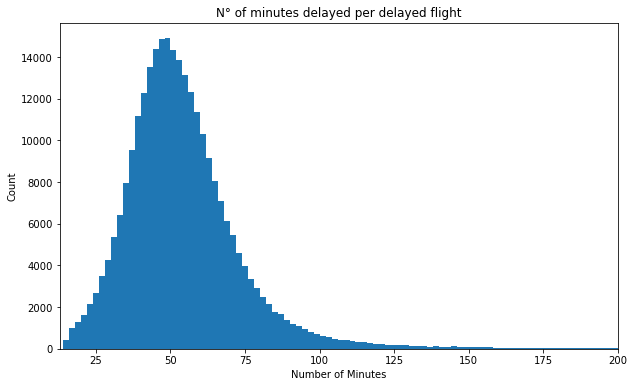

In [31]:
base_color=sb.color_palette()[0]
binsize=2
bins = np.arange(0, flights['delaymin_per_flight'].max()+binsize, binsize)

plt.figure(figsize = [10, 6])
plt.hist(data=flights,x='delaymin_per_flight',color=base_color, bins=bins)
plt.title('N° of minutes delayed per delayed flight')
plt.xlabel('Number of Minutes')
plt.ylabel('Count')
plt.xlim(13,200);

## Distribution for the porcentage of delayed flights from the total arrived flights

The distribution is a little skewed to the left with a mean around 20% and a mode around 18% of flights delayed per each observation.

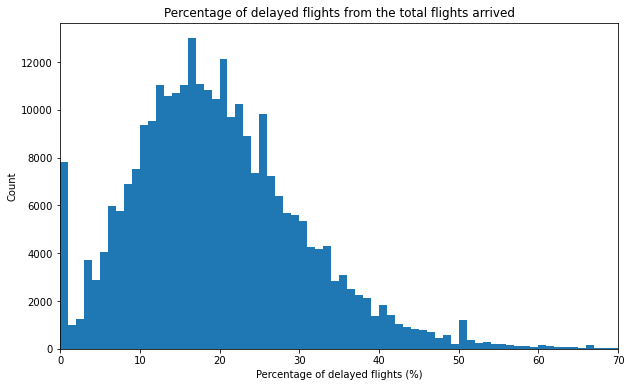

In [32]:
binsize=1
bins = np.arange(0, flights['delayed_ratio_ct'].max()+binsize, binsize)

plt.figure(figsize = [10, 6])
plt.hist(data=flights,x='delayed_ratio_ct',color=base_color, bins=bins)
plt.title('Percentage of delayed flights from the total flights arrived')
plt.xlabel('Percentage of delayed flights (%)')
plt.ylabel('Count')
plt.xlim(0,70);

## Distribution for the porcentage of cancelled flights

Thanks to the logarithmic scale transformation, we can see that the porcentage of cancelled flights behaves like a bimodal normal distribution with two peaks at 1.8% and 3.5% of cancellations.

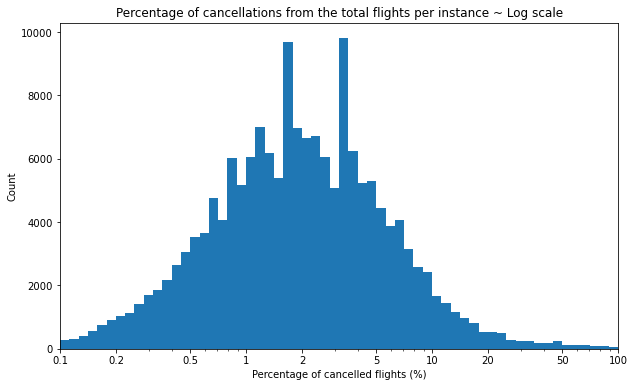

In [33]:
log_binsize = 0.05
bins = 10**np.arange(-1, np.log10(flights['cancelled_ratio_ct'].max())+log_binsize, log_binsize)

plt.figure(figsize = [10, 6]) 
plt.hist(data=flights,x='cancelled_ratio_ct',color=base_color, bins=bins);
plt.title('Percentage of cancellations from the total flights per instance ~ Log scale')
plt.xlabel('Percentage of cancelled flights (%)')
plt.ylabel('Count');
plt.xscale('log')
plt.xlim(0.1,100)
plt.xticks([0.1,0.2,0.5,1,2, 5, 10, 20, 50, 100], [0.1,0.2,0.5,1,2, 5, 10, 20, 50, 100]);

## Mean Number of delayed flights & the mean duration of delayed flights by type of delay

The late_aircraft is the type of delay that occurs more times and whose durations are longer than the rest on average. On the other hand, security and weather remain as the reasons for the least occurrence and as the shortest delays. Something interesting happens with the nas and carrier types because on average a greater number of flights are delayed for nas reasons but the durations of delays per carrier are longer on average.

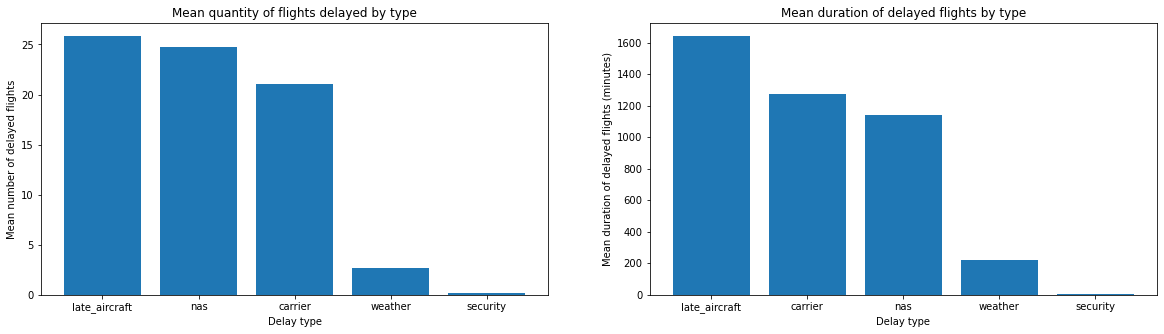

In [34]:
x1=fligts_ct_min.groupby('delay_type')['delayed_ct'].mean().sort_values(ascending=False).index.values
y1=fligts_ct_min.groupby('delay_type')['delayed_ct'].mean().sort_values(ascending=False).values
x2=fligts_ct_min.groupby('delay_type')['delayed_min'].mean().sort_values(ascending=False).index.values
y2=fligts_ct_min.groupby('delay_type')['delayed_min'].mean().sort_values(ascending=False).values

plt.figure(figsize = [20, 5])
plt.subplot(1, 2, 1)
plt.bar(x1,y1)
plt.title('Mean quantity of flights delayed by type')
plt.xlabel('Delay type')
plt.ylabel('Mean number of delayed flights');

plt.subplot(1, 2, 2)
plt.bar(x2,y2)
plt.title('Mean duration of delayed flights by type')
plt.xlabel('Delay type')
plt.ylabel('Mean duration of delayed flights (minutes)');

## Distribution for the delay-types for delayed flights by year

The annual graph shows an abrupt rise in delays with respect to carrier (airline) and nas (National Aviation Services) types of delay, a direct consequence of the pandemic as more exhaustive sanitation protocols were added. This is justified with a lower number of delayed flights by late_aircraft since due to the pandemic the number of flights has been abysmally reduced and there is not so much demand so there are more unoccupied planes. You can also see a steady increase in the number of delays caused by late_aircraft until 2019.

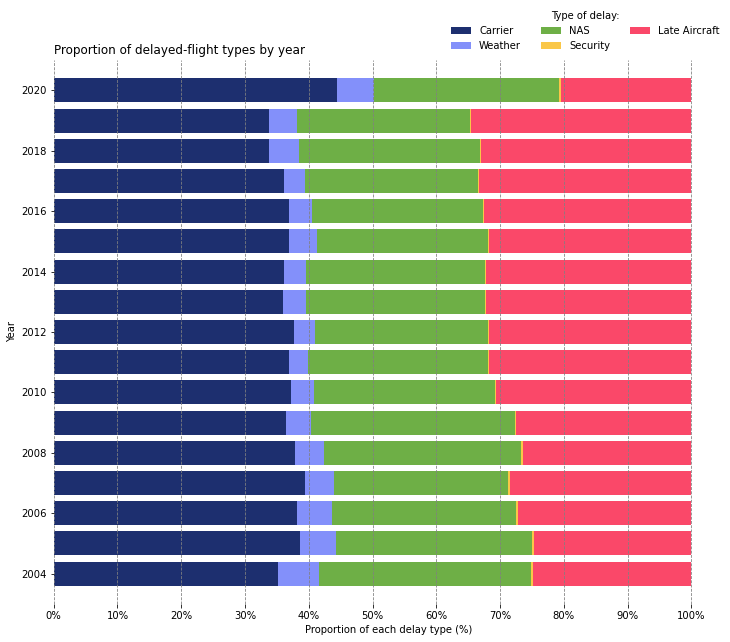

In [35]:
# dataset & variables
flights_year = flights_withNa.groupby('year').mean()[['carrier_ratio_ct','weather_ratio_ct','nas_ratio_ct','security_ratio_ct','late_aircraft_ratio_ct']]
labels = ['Carrier', 'Weather', 'NAS', 'Security','Late Aircraft']
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748','#FA4869']
title = 'Proportion of delayed-flight types by year'

def plot_stackedbar_p(df, labels, colors, title):
    fields = df.columns.tolist()
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 10))
    # plot bars
    left = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.barh(df.index, df[name], left = left, color=colors[idx])
        left = left + df[name]
    # title and subtitle
    plt.title(title, loc='left')
    # legend
    plt.legend(labels, bbox_to_anchor=([0.58, 1, 0, 0]), ncol=3, frameon=False, loc='best',title='Type of delay:')
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # format x ticks
    xticks = np.arange(0,110,10)
    xlabels = ['{}%'.format(i) for i in np.arange(0,110,10)]
    plt.xticks(xticks, xlabels)
    plt.xlabel('Proportion of each delay type (%)')
    plt.ylabel('Year')
    # adjust limits and draw grid lines
    plt.ylim(2003,2021)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    
plot_stackedbar_p(flights_year, labels, colors, title)

## Distribution of delay-types for delayed flights by month

Looking for the types of delays vs the month variable is useful to determine if there are seasonality, especially for the type of weather delay that presents its lowest values on average in the months of March, April, September and October. This is because, apparently, it is the fall and spring times with the least problems generated by the weather. On the other hand, delayed flights by carrier present their highest value in July and the lowest in September.

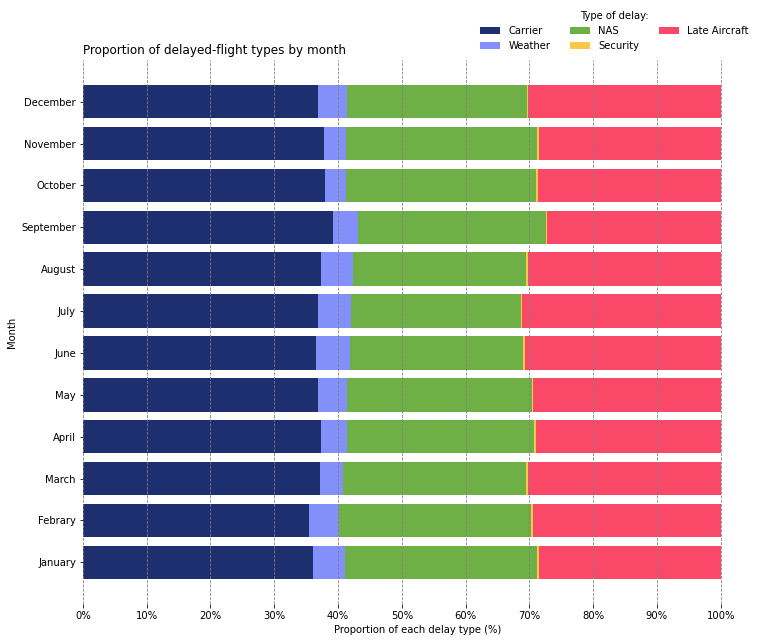

In [36]:
# dataset & variables
flights_month = flights_withNa.groupby('month_ch').mean()[['month','carrier_ratio_ct','weather_ratio_ct','nas_ratio_ct','security_ratio_ct','late_aircraft_ratio_ct']].sort_values('month')
flights_month = flights_month.drop('month',axis=1)

labels = ['Carrier', 'Weather', 'NAS', 'Security','Late Aircraft']
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748','#FA4869']
title = 'Proportion of delayed-flight types by month'

def plot_stackedbar_p(df, labels, colors, title):
    fields = df.columns.tolist()
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 10))
    # plot bars
    left = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.barh(df.index, df[name], left = left, color=colors[idx])
        left = left + df[name]
    # title and subtitle
    plt.title(title, loc='left')
    # legend
    plt.legend(labels, bbox_to_anchor=([0.58, 1, 0, 0]), ncol=3, frameon=False, loc='best', title='Type of delay:')
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # format x ticks
    xticks = np.arange(0,110,10)
    xlabels = ['{}%'.format(i) for i in np.arange(0,110,10)]
    plt.xticks(xticks, xlabels)
    plt.xlabel('Proportion of each delay type (%)')
    plt.ylabel('Month')
    # adjust limits and draw grid lines
    ax.xaxis.grid(color='gray', linestyle='dashed')

plot_stackedbar_p(flights_month, labels, colors, title)

## Behaviour of the porcentage of flights delayed by month and type of delay

When viewing the visualization, a marked seasonality can be clearly appreciated the quantity of flights delayed by carrier, late_aircraft, nas and, with less strength, weather. The security cause of delay has the same seasonality but because of its fewer occurrence its not appreciable.

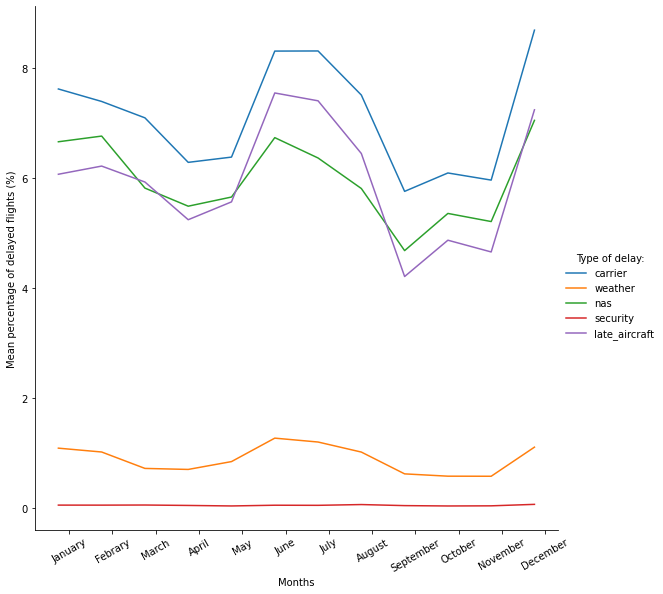

In [24]:
bin_edges = np.arange(0.25, fligts_ct_min['month'].max()+0.5, 1)

g = sb.FacetGrid(data = fligts_ct_min, hue = 'delay_type', height = 8)
g.map(mean_poly, "month", "delayed_ct_ratio", bins = bin_edges)
g.set_ylabels('Mean percentage of delayed flights (%)')
g.set_xlabels('Months')
g.add_legend(title='Type of delay:')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], ['January','Febrary','March','April','May','June','July','August','September','October','November','December'])
plt.xticks(rotation='30');

In [1]:
!jupyter nbconvert Explanatory_Presentation.ipynb --to slides --post serve  --no-input --no-prompt 

^C
